# Neural machine translation with attention

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/

In [2]:
!wget http://www.manythings.org/anki/swe-eng.zip

--2021-10-18 06:48:36--  http://www.manythings.org/anki/swe-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 630671 (616K) [application/zip]
Saving to: ‘swe-eng.zip’

swe-eng.zip         100%[===================>] 615.89K  --.-KB/s    in 0.1s    

2021-10-18 06:48:36 (6.29 MB/s) - ‘swe-eng.zip’ saved [630671/630671]



In [3]:
!mkdir swe-eng
!unzip swe-eng -d swe-eng/

Archive:  swe-eng.zip
  inflating: swe-eng/_about.txt      
  inflating: swe-eng/swe.txt         


In [4]:
!ls /content/swe-eng/ -lah

total 2.6M
drwxr-xr-x 2 root root 4.0K Oct 18 06:48 .
drwxr-xr-x 1 root root 4.0K Oct 18 06:48 ..
-rw-r--r-- 1 root root 1.5K Jul 14 10:16 _about.txt
-rw-r--r-- 1 root root 2.6M Jul 14 10:16 swe.txt


In [5]:
# Download the file
path_to_file = "/content/swe-eng/swe.txt" 

In [6]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [7]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [8]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [9]:
en, swe = create_dataset(path_to_file, None)
print(en[-1])
print(swe[-1])

<start> i know that adding sentences only in your native or strongest language is probably not as much fun as practicing writing foreign languages , but please don't add sentences to the tatoeba corpus if you are not absolutely sure they are correct . if you want to practice languages that you are studying , please do so by using a website designed for that purpose such as www . lang . com . <end>
<start> jag vet att det nog inte r lika roligt att l gga till meningar p ditt modersm l eller starkaste spr k som att va p fr mmande spr k , men var v nlig och l gg inte till meningar i tatoebas korpus om du inte r fullst ndigt s ker p att de r korrekta . om du vill va p spr k du studerar , v nligen g r det p en hemsida avsedd f r det ndam let , s som www . lang . com . <end>


In [10]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [11]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)


In [12]:
len(en), len(swe)

(19828, 19828)

In [13]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [14]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

15862 15862 3966 3966


In [15]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
446 ----> deras
1664 ----> varor
4 ----> r
50 ----> av
13 ----> h
1994 ----> gsta
6059 ----> kvalitet
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
236 ----> their
1678 ----> goods
23 ----> are
21 ----> of
8 ----> the
4799 ----> highest
3215 ----> quality
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [17]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 93]), TensorShape([64, 75]))

In [19]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 93, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [22]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 93, 1)


In [23]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [24]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5388)


## Define the optimizer and the loss function

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [26]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [27]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [28]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8234
Epoch 1 Batch 100 Loss 0.4324
Epoch 1 Batch 200 Loss 0.4114
Epoch 1 Loss 0.4471
Time taken for 1 epoch 738.2993533611298 sec

Epoch 2 Batch 0 Loss 0.3962
Epoch 2 Batch 100 Loss 0.3282
Epoch 2 Batch 200 Loss 0.3086
Epoch 2 Loss 0.3292
Time taken for 1 epoch 628.5054771900177 sec

Epoch 3 Batch 0 Loss 0.3103
Epoch 3 Batch 100 Loss 0.2747
Epoch 3 Batch 200 Loss 0.2203
Epoch 3 Loss 0.2587
Time taken for 1 epoch 627.6824023723602 sec

Epoch 4 Batch 0 Loss 0.1973
Epoch 4 Batch 100 Loss 0.1753
Epoch 4 Batch 200 Loss 0.2084
Epoch 4 Loss 0.2013
Time taken for 1 epoch 628.3449640274048 sec

Epoch 5 Batch 0 Loss 0.1550
Epoch 5 Batch 100 Loss 0.1622
Epoch 5 Batch 200 Loss 0.1293
Epoch 5 Loss 0.1539
Time taken for 1 epoch 627.2844865322113 sec

Epoch 6 Batch 0 Loss 0.1054
Epoch 6 Batch 100 Loss 0.1294
Epoch 6 Batch 200 Loss 0.1342
Epoch 6 Loss 0.1150
Time taken for 1 epoch 627.9055542945862 sec

Epoch 7 Batch 0 Loss 0.0709
Epoch 7 Batch 100 Loss 0.0832
Epoch 7 Batch 200 

KeyboardInterrupt: ignored

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [29]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [30]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [31]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [32]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> det r trevligt h r . <end>
Predicted translation: it's good . <end> 


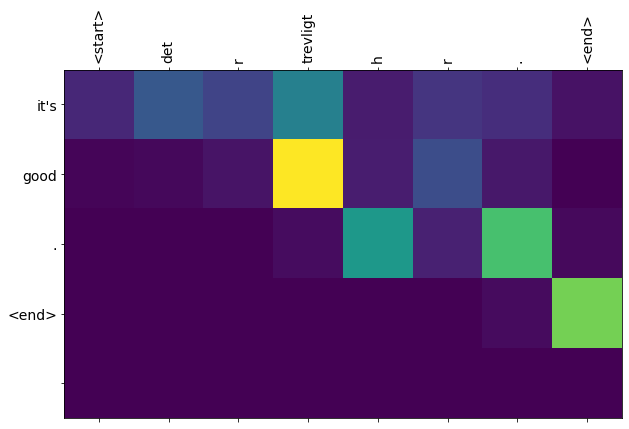

In [56]:
translate(u'Det är trevligt här.')

Input: <start> jag kan inte g . <end>
Predicted translation: i can't go . <end> 


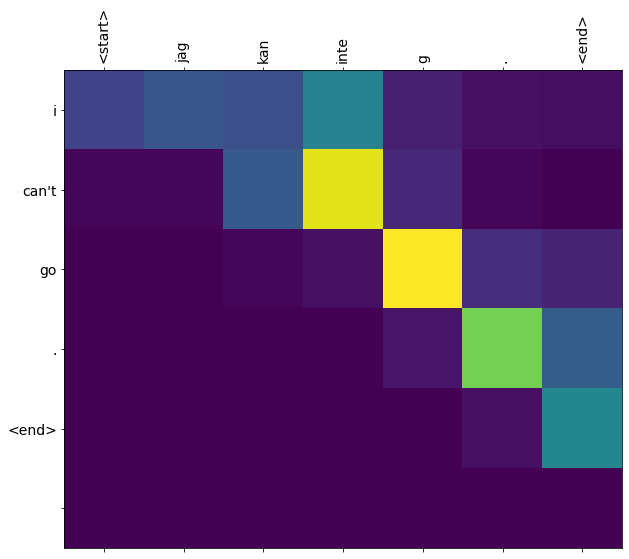

In [55]:
translate(u'jag kan inte gå.')

Input: <start> r du fortfarande hemma ? <end>
Predicted translation: are you still at home ? <end> 


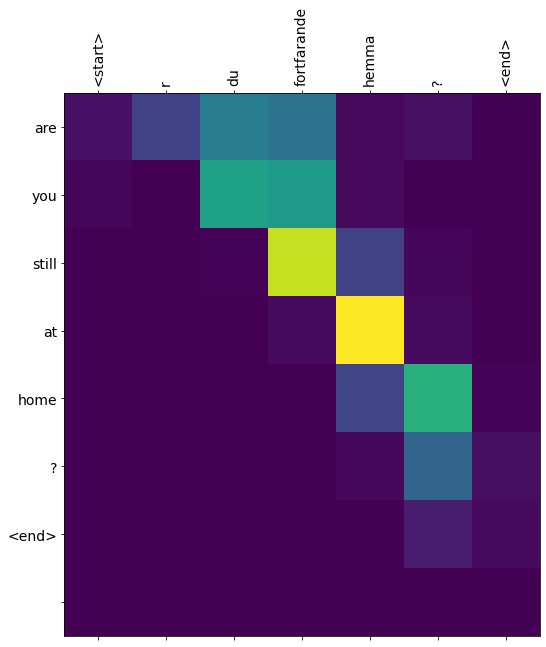

In [54]:
translate(u'är du fortfarande hemma?')

Input: <start> f rs k att g ra det . <end>
Predicted translation: try and do it . <end> 


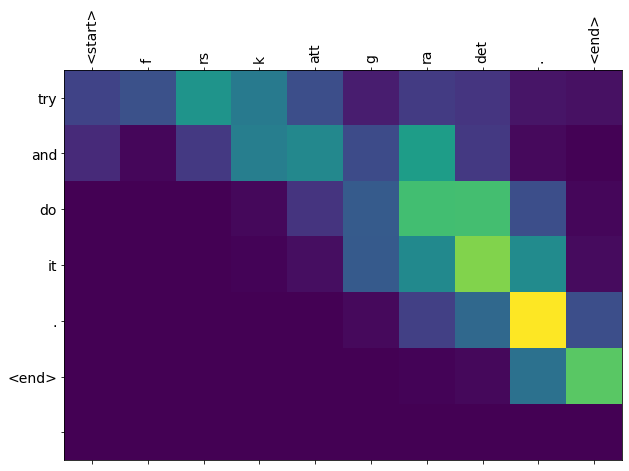

In [50]:
translate(u'försök att göra det.')

Input: <start> prova detta . <end>
Predicted translation: try on this . <end> 


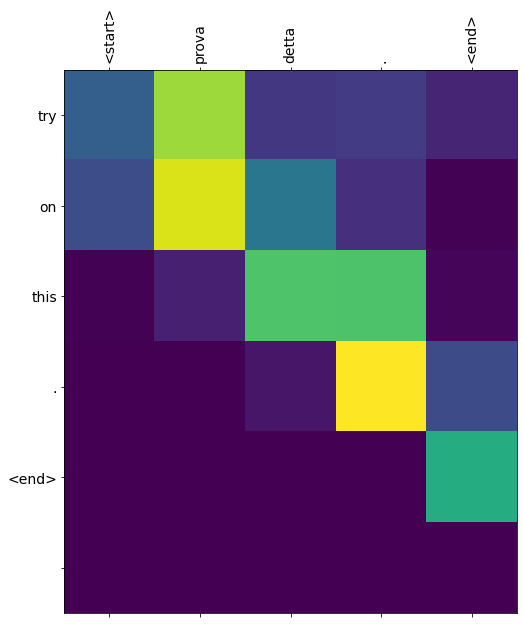

In [51]:
translate(u'Prova detta.')

Input: <start> jag gillar det inte n r det sn ar . <end>
Predicted translation: i don't like that it's . <end> 


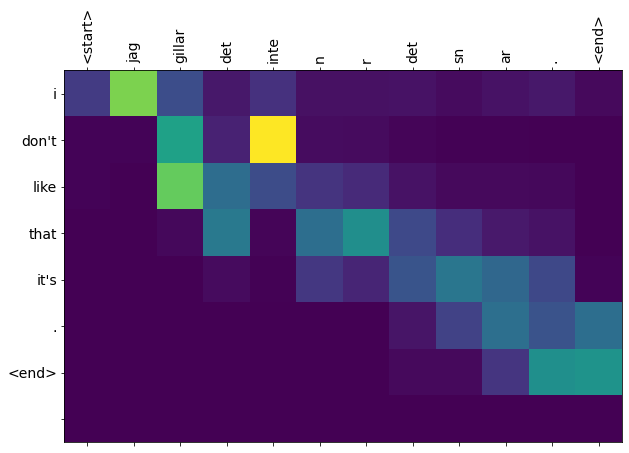

In [52]:
translate(u'Jag gillar det inte när det snöar.')

Input: <start> jag g r aldrig det . <end>
Predicted translation: i never do that . <end> 


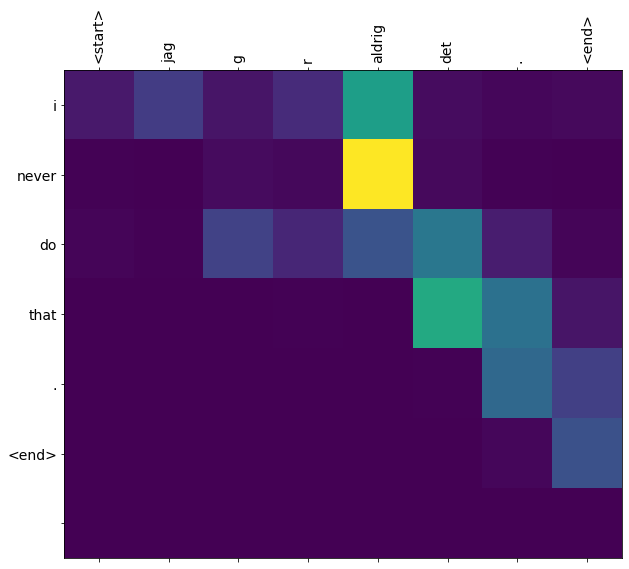

In [53]:
translate(u'Jag gör aldrig det.')